In [1]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import numpy as np

/Users/subsid/.virtualenvs/p3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
## computes the p_i for any x_i and beta
def logistic(x,beta):
    return( 1 / (1+np.exp(-np.sum(x*beta))))

def generate_mislabeled_data(n, alpha):
    x = np.linspace(-5,5,num=n)
    beta = np.array([3.,1.])
    X = np.column_stack((np.ones(n),x))

    p = np.apply_along_axis(lambda y: logistic(y,beta),1,X)

    ## simulate responses
    y = np.random.binomial(n=1,p=p)

    ## contamination level alpha
    z = np.random.binomial(n=1,p=1-alpha,size=n)
    r = np.random.binomial(n=1,p=0.5,size=n)

    ## we observe data w
    w = y*z + r*(1-z)
    
    return X, w

In [3]:
def identifyMisLabeled(X_train, Y_train, X_test, Y_test, clf, test_index, mismatches):
    # train scikit learn model
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    i = 0
    for d, c in zip(Y_test, Y_pred):
        if(d != c):
            mismatches[test_index[i]] += 1
        i += 1

In [13]:
# Training Dataset created with some contamination level
X_orig, Y_orig = generate_mislabeled_data(1000, 0.4)

# Test Dataset created with no contamination level
X_test, Y_test = generate_mislabeled_data(10000, 0.0)

kf = KFold(n_splits=10)

# Array of mismatches is created to store the number of times
# element at that index is identified as mislabeled by different models.
mismatches = np.zeros(shape = Y_orig.shape)

# For each combination of splits using cross-validation
for train_index, test_index in kf.split(X_orig):
    X_train, X_test = X_orig[train_index], X_orig[test_index]
    Y_train, Y_test = Y_orig[train_index], Y_orig[test_index]

    # LogisticRegressionClassifier
    identifyMisLabeled(X_train, Y_train, X_test, Y_test, LogisticRegression(), test_index, mismatches)

    # RandomForestClassifier
    identifyMisLabeled(X_train, Y_train, X_test, Y_test, RandomForestClassifier(max_depth=2, random_state=0),
                       test_index, mismatches)

print('Original dataset size : ', X_orig.shape[0])

# X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.33)
clf = LogisticRegression()
clf.fit(X_orig, Y_orig)
print('Score without removing Mislabeled Data: ', clf.score(X_test, Y_test))

# Removing all the entries which are counted as mislabed by both classifiers
indexes = np.where(mismatches > 1)[0]
X_filtered = np.delete(X_orig, indexes, 0)
Y_filtered = np.delete(Y_orig, indexes)

print('Dataset size after removing Mislabeled Data : ', X_orig.shape[0])

X_train,X_test,Y_train,Y_test = train_test_split(X_filtered,Y_filtered,test_size=0.33)
clf = LogisticRegression()
clf.fit(X_train, Y_train)
print('Score after removing Mislabeled Data: ', clf.score(X_test, Y_test))

Original dataset size :  1000
Score without removing Mislabeled Data:  0.84
Dataset size after removing Mislabeled Data :  1000
Score after removing Mislabeled Data:  0.948616600791


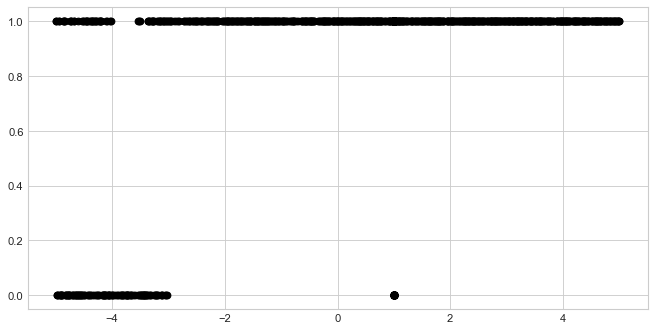

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.style.use('seaborn-whitegrid')
plt.plot(X_orig,Y_orig,'o',color='black')
plt.plot(x,p)
plt.xlabel("x")
plt.ylabel("y")
# plt.ylim(-.1,1.1);